# Линейная регрессия. Бостон

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt

Загрузим датасет про цены на дома в Бостоне и посмотрим описание данных, нам нужно предсказать медиану цены жилья в 506 районах. Некоторые признаки у нас уже посчитаны.

Для реализации будем использовать матричные операции:

$ y = X\theta +\epsilon $

Из данного следует выражение для $\theta$ как:

$ X^Ty=X^TX\theta \rightarrow \theta=(X^TX)^{-1}X^Ty $

Подготавливаем данные и вычисляем параметр $\theta$:

In [90]:
data = load_boston()
data['data'].shape

(506, 13)

In [59]:
print(data['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [53]:
# Задание 6.1. Реализуйте матричную линейную регрессию. Какой получился RMSE?

def linreg_linear(x, y):
    theta = np.linalg.inv(x.T @ x) @ x.T @ y
    
    return theta

In [91]:
X, y = data['data'], data['target']
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

theta = linreg_linear(X, y)

Сделаем предсказание и посчитаем метрики:

In [29]:
def print_regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f'MSE = {mse:.2f}, RMSE = {rmse:.2f}')

In [30]:
y_pred = X.dot(theta)

Посчитать значение ошибок *MSE* и *RMSE* для тренировочных данных:

In [31]:
print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


В чём проблема такого подхода? Мы обучили модель на неких данных и на них же посчитали метрики, обычно же выборку делят на обучающую и валидационную. Давайте разобьём выборку на `train/valid`, вычислим $\theta$, сделаем предсказания и посчитаем ошибки *MSE* и *RMSE*:

In [54]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = linreg_linear(X_train, y_train)
y_pred = X_valid.dot(theta)
y_train_pred = X_train.dot(theta)

In [55]:
print_regression_metrics(y_train, y_train_pred)

MSE = 22.45, RMSE = 4.74


In [56]:
print_regression_metrics(y_valid, y_pred)

MSE = 20.20, RMSE = 4.49


В итоге тренировочная выборка дала лучший результат, чем был, а валидационная — наоборот. Это значит, что модель значительно **переобучилась**.

Построим классификатор с помощью методов **оптимизации**. Воспользуемся функцией ошибки **среднего квадратичного**:

$ MSE = \frac{1}{n} * \sum_{i=1}^{n}{(y_i - a(x_i))^2} $

В случае линейной регрессии $MSE$ представляется как:

$ MSE(X, y, \theta) = \frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} = \frac{1}{2n} \lVert{y - X\theta}\rVert_{2}^{2}=\frac{1}{2n} (y - X\theta)^T(y - X\theta) $

Возьмём первый вариант представления функции ошибки и посчитаем её градиент по параметру $\theta$, предварительно переименовав $MSE$ в $L$:

$ L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} $

$ \nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} = \frac{1}{n}X^T(X\theta - y) $

Реализуем функцию вычисления градиента функции $MSE$ и шаг градиентного спуска:

In [57]:
def calc_mse_gradient(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(X.dot(theta) - y)
    
    return grad

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad

Сделаем процедуру **оптимизации**:

In [58]:
def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta

Оптимизируем параметр **линейной регрессии** $\theta$ на всех данных:

In [68]:
m = X.shape[1]
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.001, 100)

Градиент получился очень большой, у нас вышло переполнение и $\theta$ выдала значения `nan`. Для того, чтобы этого избежать, нужно применить стандартную **нормализацию**:

In [64]:
X, y = data['data'], data['target']
X = (X - X.mean(axis=0)) / X.std(axis=0)

Оптимизируем $\theta$ на новых данных:

In [70]:
m = X.shape[1]
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.01, 5000)

Сделаем предсказание, посчитаем значение ошибок:

In [71]:
y_pred = X.dot(theta)
print_regression_metrics(y, y_pred)

MSE = 529.62, RMSE = 23.01


Разобьём выборку на `train/valid`, оптимизируем $\theta$, сделаем предсказания и посчитаем ошибки *MSE* и *RMSE*:

In [72]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = optimize(X_train, y_train, calc_mse_gradient, np.ones(m), 0.01, 5000)
y_pred = X_valid.dot(theta)

print_regression_metrics(y_valid, y_pred)

MSE = 583.98, RMSE = 24.17


In [81]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

solver = LinearRegression()
solver.fit(X_train, y_train)
y_pred = solver.predict(X_test)

print_regression_metrics(y_test, y_pred)

MSE = 29.29, RMSE = 5.41


In [86]:
from sklearn.linear_model import LinearRegression

## Задание 6.2 

Постройте модель при помощи sklearn. Используйте параметры по умолчанию, обучите на всей выборке и посчитайте RMSE.

In [151]:
X, y = data['data'], data['target']
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

solver = LinearRegression()
solver.fit(X, y)
y_pred = solver.predict(X)

print_regression_metrics(y, y_pred)

## Задание 6.4

Обучите регрессию без дополнительного столбца единиц. Какой получился RMSE? 

In [156]:
X, y = data['data'], data['target']
# X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

solver = LinearRegression()
solver.fit(X, y)
y_pred = solver.predict(X)

print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


## Задание 6.5

Очистите данные от строк, где значение признака $B$ меньше 50. Какой получился RMSE? 

In [179]:
X, y = data['data'], data['target']

df = pd.DataFrame(
    data=np.hstack([X, y.reshape(-1,1)]),
    columns=list(data['feature_names']) + ['target']
)
df

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


<AxesSubplot:>

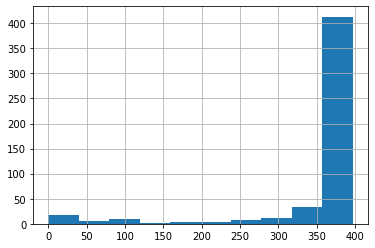

In [181]:
df['B'].hist()

In [182]:
x = df[df['B'] >= 50]

X = df.drop('target', axis=1).values
y = df['target'].values

solver = LinearRegression()
solver.fit(X, y)
y_pred = solver.predict(X)

print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


## Задание 6.6

Нормализуйте признаки и обучите линейную регрессию матричным методом. Какой получился RMSE? 

In [183]:
from sklearn.preprocessing import StandardScaler

In [196]:
X, y = data['data'], data['target']
y = y.reshape(-1, 1)

scaler = StandardScaler()
X = scaler.fit_transform(X)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])

theta = linreg_linear(X, y)
y_pred = X.dot(theta)

print_regression_metrics(y, y_pred)

MSE = 21.89, RMSE = 4.68


### 1.2. Реализация линейной регрессии с использованием методов оптимизации

Для реализации линейной регрессии с помощью методов оптимизации будем использовать функцию ошибки **среднего квадратичного** ([Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error)), которая является выпуклой функцией в n-мерном пространстве $\mathbb{R}^n$ и в общем виде выглядит следующим образом:
$$MSE = \frac{1}{n} * \sum_{i=1}^{n}{(y_i - a(x_i))^2}.$$
Здесь $x_i$ — вектор-признак $i$-го объекта обучающей выборки, $y_i$ — истинное значение для $i$-го объекта, $a(x)$ — алгоритм, предсказывающий для данного объекта $x$ целевое значение, $n$ — кол-во объектов в выборке.

В случае линейной регрессии $MSE$ представляется как:
$$MSE(X, y, \theta) = \frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2} = \frac{1}{2n} \lVert{y - X\theta}\rVert_{2}^{2}=\frac{1}{2n} (y - X\theta)^T(y - X\theta),$$
где $\theta$ — параметр модели линейной регрессии, $X$ — матрица объекты-признаки, $y$ - вектор истинных значений, соответствующих $X$.

Возьмем первый вариант представления функции ошибки и посчитаем ее градиент по параметру $\theta$, предварительно переименовав $MSE$ в $L$:
$$L=\frac{1}{2n} * \sum_{i=1}^{n}{(y_i - \theta^Tx_i)^2}$$
$$\nabla L = \frac{1}{n}\sum_{i=1}^{n}{(\theta^Tx_i - y_i) \cdot x_i} = \frac{1}{n}X^T(X\theta - y)$$

Исходя из полученного выражения градиента, реализуем алгоритм градиентного спуска:

In [77]:
# Реализовать функцию вычисления градиента функции MSE

def calc_mse_gradient(X, y, theta):
    n = X.shape[0]
    grad = 1. / n * X.transpose().dot(X.dot(theta) - y)
    
    return grad

In [78]:
# Реализовать функцию, осуществляющую градиентный шаг
# (функция должна содержать параметр величины шага alpha - learning rate)

def gradient_step(theta, theta_grad, alpha):
    return theta - alpha * theta_grad

In [79]:
# Реализовать функцию цикла градиентного спуска с доп. параметрами
# начального вектора theta и числа итераций

def optimize(X, y, grad_func, start_theta, alpha, n_iters):
    theta = start_theta.copy()
    
    for i in range(n_iters):
        theta_grad = grad_func(X, y, theta)
        theta = gradient_step(theta, theta_grad, alpha)
    
    return theta


In [95]:
# Разбить таблицу данных на матрицы X и y
X, y = data['data'], data['target']

# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
m = X.shape[1]

In [101]:
# Оптимизировать параметр линейной регрессии theta на всех данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.001, 100)

In [102]:
theta

array([7.41647399e+246, 3.32349992e+247, 7.39564172e+247, 8.96295209e+247,
       5.07578059e+245, 4.22030567e+246, 4.63094053e+247, 5.29083888e+248,
       2.65643383e+247, 8.19991211e+247, 3.27135991e+249, 1.38363846e+248,
       2.64323053e+249, 9.88835598e+247])

In [83]:
# Проверить максимальные значения по каждому признаку в данных
X.max(axis=0)

array([  1.    ,  88.9762, 100.    ,  27.74  ,   1.    ,   0.871 ,
         8.78  , 100.    ,  12.1265,  24.    , 711.    ,  22.    ,
       396.9   ,  37.97  ])

In [113]:
print(data['feature_names'][np.argmax(X.std(axis=0)) + 1])
print(np.max(X.std(axis=0)))

B
168.3704950393814


In [84]:
# Нормализовать даннные с помощью стандартной нормализации
X, y = data['data'], data['target']
X = (X - X.mean(axis=0)) / X.std(axis=0)

In [85]:
# Добавить фиктивный столбец единиц (bias линейной модели)
X = np.hstack([np.ones(X.shape[0])[:, np.newaxis], X])
X.max(axis=0)

array([1.        , 9.9339306 , 3.80423444, 2.42256516, 3.66839786,
       2.73234648, 3.55504427, 1.11749449, 3.96051769, 1.66124525,
       1.79819419, 1.63882832, 0.44105193, 3.54877081])

In [86]:
# Оптимизировать theta на новых данных
theta = optimize(X, y, calc_mse_gradient, np.ones(m), 0.01, 5000)

In [87]:
theta

array([ 2.25328063e+01, -9.21740195e-01,  1.07033639e+00,  1.06388396e-01,
        6.86667316e-01, -2.05006416e+00,  2.68062168e+00,  1.40667969e-02,
       -3.10608483e+00,  2.57511475e+00, -1.97802851e+00, -2.05725099e+00,
        8.48690321e-01, -3.74025884e+00])

In [88]:
# Сделать предсказания при полученных параметрах
y_pred = X.dot(theta)

In [89]:
# Посчитать значение ошибок MSE и RMSE для тренировочных данных
print_regression_metrics(y, y_pred)

MSE = 21.90, RMSE = 4.68


In [90]:
# Разбить выборку на train/valid, оптимизировать theta,
# сделать предсказания и посчитать ошибки MSE и RMSE

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2)
theta = optimize(X_train, y_train, calc_mse_gradient, np.ones(m), 0.01, 5000)
y_pred = X_valid.dot(theta)

print_regression_metrics(y_valid, y_pred)

MSE = 20.44, RMSE = 4.52
